This is a solution for the ride hailing problem, where we predict the demand (riders) vs. the supply (drivers) to guide drivers to locations where a higher demand is expected with a lack of supply.

We start the solution with some EDA and data preparation/feature engineering, then we proceed to selecting, training, then validating the prediction model.

In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import geopy.distance
from statistics import mean

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, PoissonRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
df = pd.read_csv("robotex5.csv")
df.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
0,2022-03-06 15:02:39.329452000,59.407910,24.689836,59.513027,24.831630,3.51825
1,2022-03-10 11:15:55.177526000,59.441650,24.762712,59.426450,24.783076,0.50750
2,2022-03-06 14:23:33.893257000,59.435404,24.749795,59.431901,24.761588,0.19025
3,2022-03-03 09:11:59.104192000,59.406920,24.659006,59.381093,24.641652,0.75600
4,2022-03-06 00:13:01.290346000,59.434940,24.753641,59.489203,24.876170,2.27100


In [4]:
df.shape

(627210, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627210 entries, 0 to 627209
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   start_time  627210 non-null  object 
 1   start_lat   627210 non-null  float64
 2   start_lng   627210 non-null  float64
 3   end_lat     627210 non-null  float64
 4   end_lng     627210 non-null  float64
 5   ride_value  627210 non-null  float64
dtypes: float64(5), object(1)
memory usage: 28.7+ MB


In [6]:
df.duplicated().value_counts()

False    622646
True       4564
Name: count, dtype: int64

In [7]:
df = df.drop_duplicates()
df.shape

(622646, 6)

In [8]:
df.describe()

,start_lat,start_lng,end_lat,end_lng,ride_value
count,622646.000000,622646.000000,622646.000000,622646.000000,622646.000000
mean,59.428683,24.743474,59.397579,24.724682,2.268597
std,0.021761,0.056870,1.397846,1.656725,45.053886
min,59.321557,24.505199,-37.819979,-122.453962,0.107628
25%,59.418812,24.713154,59.415213,24.707899,0.545250
50%,59.432070,24.744677,59.430697,24.744334,1.059000
75%,59.439024,24.768124,59.439262,24.773922,1.712000
max,59.566998,24.973743,61.552744,144.966110,3172.701000


we notice that the std of the ride_value is relatively big and there is a big difference between the 75 percentile and the max value. We confirm this using the box plot

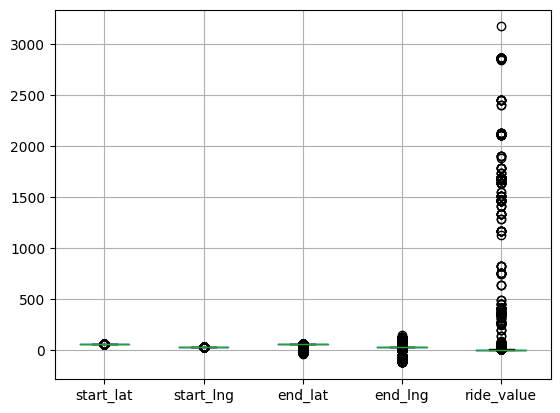

In [9]:
df.boxplot();

we notice that we have some extreme points that might correspond to some outlier, so we will check for outliers in the next steps

**Initial Feature Engineering**

we notice from df.info that the start_date is a string so we convert it to the proper type in order to perform feature engineering

In [10]:
df["start_time"] = pd.to_datetime(pd.to_datetime(df['start_time']).dt.strftime('%Y-%m-%d %H:%M:%S'))

df["start_date"] = df["start_time"].dt.date
df["start_month"] = df["start_time"].dt.month
df["start_day"] = df["start_time"].dt.day
df["start_hour"] = df["start_time"].dt.hour
df["start_minute"] = df["start_time"].dt.minute
df["start_day_of_week"] = df["start_time"].dt.dayofweek 
#The day of the week with Monday=0, Sunday=6 so we add 1 to make it easier to follow
df["start_day_of_week"] = df["start_day_of_week"] + 1
df["start_day_name"] = df["start_time"].dt.day_name()

df["is_weekend"] = df["start_day_of_week"].apply(lambda day: True if day in [6, 7] else False)

df = df.sort_values(by="start_time")
df.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,start_date,start_month,start_day,start_hour,start_minute,start_day_of_week,start_day_name,is_weekend
589247,2022-03-01 00:00:07,59.438142,24.728677,59.553133,24.802705,3.35200,2022-03-01,3,1,0,0,2,Tuesday,False
613394,2022-03-01 00:00:17,59.443230,24.753330,59.391667,24.722047,1.49500,2022-03-01,3,1,0,0,2,Tuesday,False
557451,2022-03-01 00:00:20,59.431849,24.768252,59.433692,24.728579,0.55275,2022-03-01,3,1,0,0,2,Tuesday,False
266890,2022-03-01 00:00:20,59.439587,24.748874,59.452895,24.871234,1.73725,2022-03-01,3,1,0,0,2,Tuesday,False
191825,2022-03-01 00:00:25,59.367751,24.645455,59.396104,24.800205,2.28675,2022-03-01,3,1,0,0,2,Tuesday,False


Let's calculate the distance of each trip since we have the coordinates of the start and the end. The distance feature would be helpful to get better insights in the EDA phase.

In [11]:
df["distance"] = df.apply(lambda ride: geopy.distance.distance((ride["start_lat"], ride["start_lng"]), (ride["end_lat"], ride["end_lng"])).km, axis=1)

In [12]:
df["distance"].describe()

count    622646.000000
mean          9.524009
std         198.578126
min           0.005908
25%           2.214193
50%           4.301014
75%           6.963606
max       15209.151074
Name: distance, dtype: float64

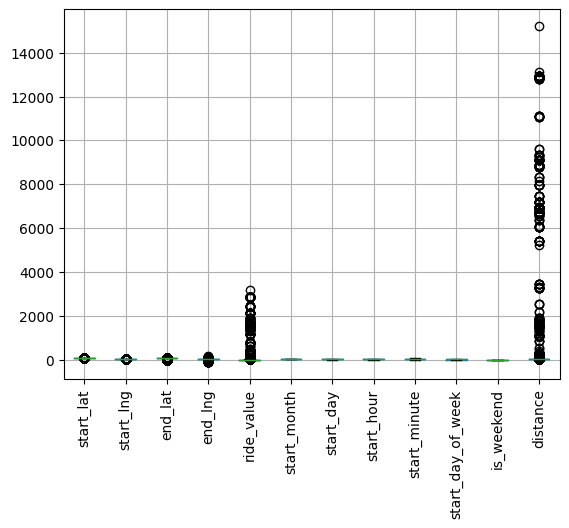

In [13]:
df.boxplot();
plt.xticks(rotation=90)
plt.show()

we notice that the max distance is not likely to be a taxi ride, so we check for the outliers and we also see if they're linked to the extreme ride values previously detected.

**Outliers Detection**

In [14]:
df[df["distance"] > df["distance"].quantile(0.99)]

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,start_date,start_month,start_day,start_hour,start_minute,start_day_of_week,start_day_name,is_weekend,distance
547084,2022-03-01 00:06:49,59.428607,24.760592,59.319127,24.530173,4.410250,2022-03-01,3,1,0,6,2,Tuesday,False,17.898191
95996,2022-03-01 00:35:16,59.429139,24.774695,59.457803,24.452246,4.544000,2022-03-01,3,1,0,35,2,Tuesday,False,18.570587
484970,2022-03-01 00:40:58,59.439852,24.748554,0.000111,-0.000225,1684.817500,2022-03-01,3,1,0,40,2,Tuesday,False,6934.119947
321837,2022-03-01 00:45:38,59.425453,24.647327,59.263367,24.839706,5.230250,2022-03-01,3,1,0,45,2,Tuesday,False,21.115428
489137,2022-03-01 00:46:51,59.437166,24.750435,59.381308,24.461188,4.302000,2022-03-01,3,1,0,46,2,Tuesday,False,17.565950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425678,2022-03-28 23:29:52,59.452667,24.692580,59.318056,24.529197,4.369500,2022-03-28,3,28,23,29,1,Monday,False,17.637892
121655,2022-03-28 23:33:15,59.508113,24.829881,59.361741,24.631702,4.905000,2022-03-28,3,28,23,33,1,Monday,False,19.808468
335061,2022-03-28 23:35:17,59.453216,24.875774,59.423156,24.566660,4.369250,2022-03-28,3,28,23,35,1,Monday,False,17.857005
216744,2022-03-28 23:35:39,59.369408,24.643957,59.517112,24.829979,4.835709,2022-03-28,3,28,23,35,1,Monday,False,19.548427


we notice that some rides have huge distances, and even some of them do not seem to be taxi rides where the distance is around 6934 KM.

So we clean the extreme points and remove the top 1% to have more robust data and later better predictions of the demand vs. supply.

Usually, the IQR rule is recommended to remove the outliers, but here we can be more flexible in order to keep rides that are further than the majority but might still be valid (trips to the airports which are located further from the city center for example).

In [15]:
print(df.shape)

q_low = df["distance"].quantile(0.01)
q_hi  = df["distance"].quantile(0.99)

df = df[(df["distance"] < q_hi) & (df["distance"] > q_low)]

print(df.shape)

(622646, 15)
(610192, 15)


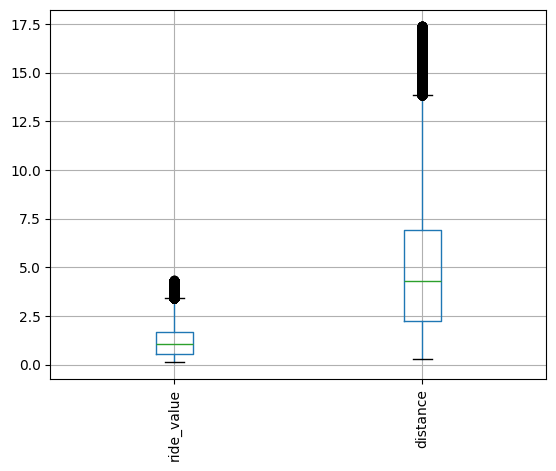

In [16]:
df[["ride_value", "distance"]].boxplot();
plt.xticks(rotation=90)
plt.show()

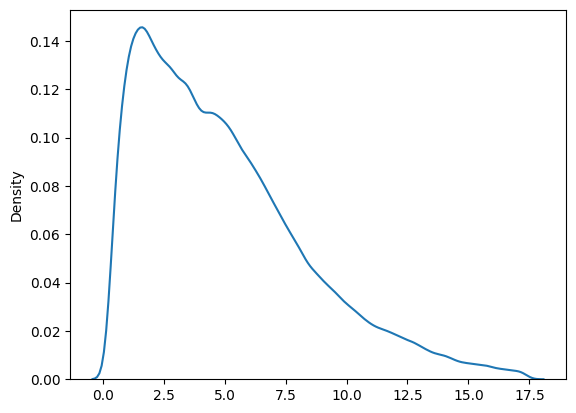

In [17]:
sns.kdeplot(df["distance"].values);
plt.show()

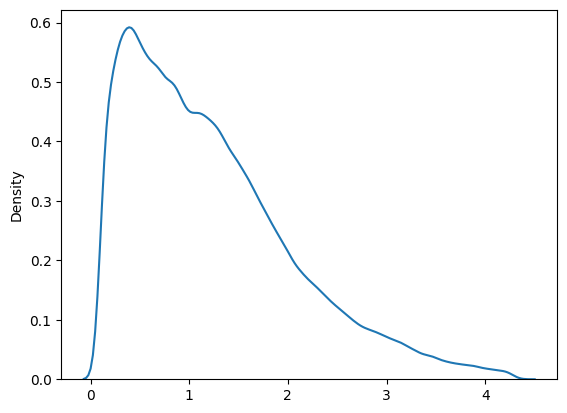

In [18]:
sns.kdeplot(df["ride_value"].values);
plt.show()

**EDA**

In [19]:
# check the ratio of weekend days
df["is_weekend"].value_counts(normalize=True)*100

is_weekend
False    70.248545
True     29.751455
Name: proportion, dtype: float64

In [20]:
df["start_month"].value_counts()

start_month
3    610192
Name: count, dtype: int64

the whole data is in one month so we cannot discover monthly patterns or patterns taking place in seasons (winter vs. summer), so our insights would focus more on weekly and daily patterns.

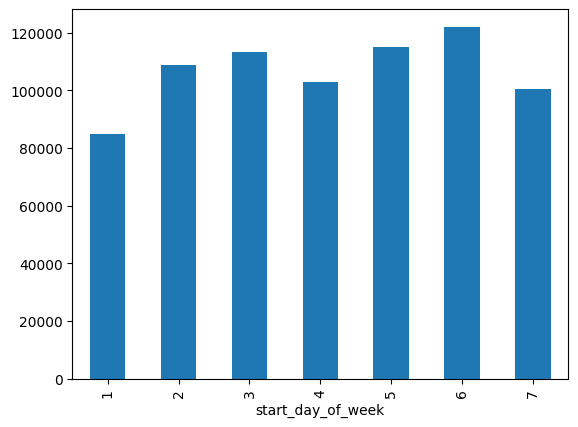

In [21]:
# total ride values per each week day
ride_value_per_week_day = df.groupby("start_day_of_week")["ride_value"].sum()
ride_value_per_week_day.plot.bar();
plt.show()

In [22]:
print(f"The weekday with the most collected ride value in March 2022 is {ride_value_per_week_day.idxmax()} with a value of {ride_value_per_week_day.max()}")

The weekday with the most collected ride value in March 2022 is 6 with a value of 122094.45381378135


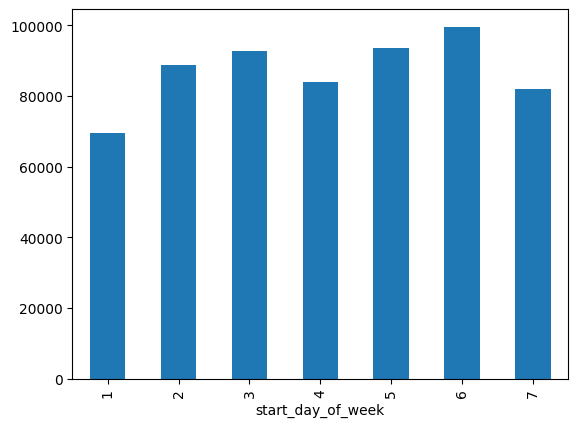

In [23]:
# count of rides per each week day
df.groupby("start_day_of_week")["ride_value"].count().plot.bar();
plt.show()

we notice that Mondays also have the less performed rides, while Saturdays are the days with the most booked rides.

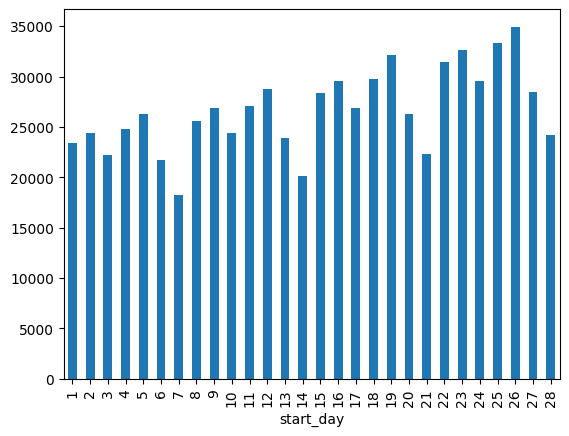

In [24]:
# total ride values per each day of the month March 2022
ride_value_per_day = df.groupby("start_day")["ride_value"].sum()
ride_value_per_day.plot.bar();
plt.show()

In [25]:
print(f"The day with the most collected ride value in March 2022 is the {ride_value_per_day.idxmax()} with a value of {ride_value_per_day.max()}")

The day with the most collected ride value in March 2022 is the 26 with a value of 34929.793316133684


if we want to analyse the previous plot from a time series perspective, then we notice that there is a weekly pattern with a positive trend, where the days with the lowest values per each week are the 7th, the 14th, the 21 and the 28th, while the week days with the highest values are the 5th, the 12th, the 19th and the 26th.

In [26]:
# the day with the lowest values in our weekly seasonality
df.loc[df["start_day"] == 7].iloc[0]["start_day_name"]

'Monday'

In [27]:
# the day with the highest values in our weekly seasonality
df.loc[df["start_day"] == 5].iloc[0]["start_day_name"]

'Saturday'

this implies a correlation between the day and the sum of values per rides, so we check the pearson correlation and we notice a positive value as we suspected.

In [28]:
df.groupby("start_day")["ride_value"].sum().reset_index().corr()

,start_day,ride_value
start_day,1.000000,0.601728
ride_value,0.601728,1.000000


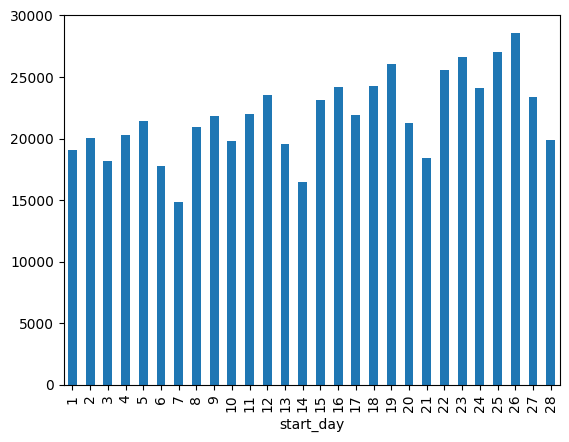

In [29]:
# total ride count per each day of the month March 2022
ride_count_per_day = df.groupby("start_day")["ride_value"].count()
ride_count_per_day.plot.bar();
plt.show()

In [30]:
print(f"The day with the most booked rides in March 2022 is the {ride_count_per_day.idxmax()} with a value of {ride_count_per_day.max()}")

The day with the most booked rides in March 2022 is the 26 with a value of 28586


let's calculate the ride value per KM to check the days where the rides where most expensive

In [31]:
#calcualte value per km
df["value_per_km"] = df["ride_value"] / df["distance"]
df["value_per_km"].describe()

count    610192.000000
mean          0.247286
std           0.010531
min           0.220201
25%           0.244820
50%           0.245968
75%           0.247610
max           0.451887
Name: value_per_km, dtype: float64

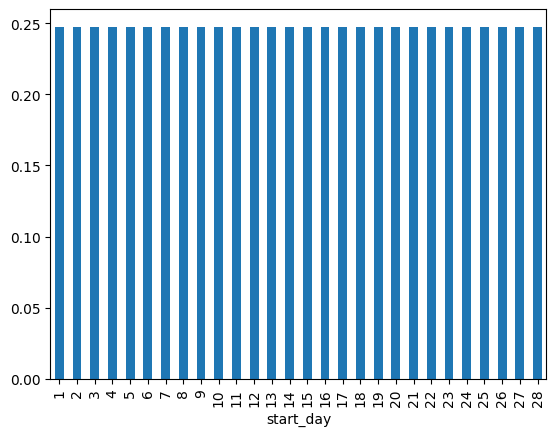

In [32]:
# check the average km price per day
average_ride_expense_per_day = df.groupby("start_day")["value_per_km"].mean()
average_ride_expense_per_day.plot.bar();
plt.show()

we notice that "how expensive" the trips are is somehow consistent throughout the month, and the same apply for the hours:

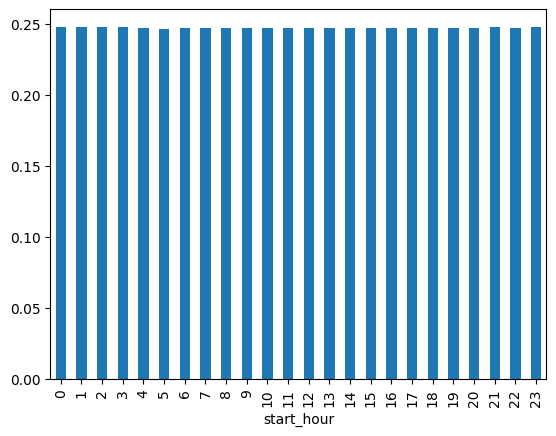

In [33]:
# check the average km price per hour
average_ride_expense_per_day = df.groupby("start_hour")["value_per_km"].mean()
average_ride_expense_per_day.plot.bar();
plt.show()

**Map Plot**

we use folium to plot the starting coordinates on an interactive map. 

Since our data set is relatively big, we only plot a sample now for the sake of simplicity.

In case the map doesn't show, select "trust notebook" from the "file" menu.

We can also change the radius of the plotted circles to be relative to the ride value itself.

In [34]:
df_plot = df.sample(n=1000)
map = folium.Map(location=[df_plot["start_lat"].mean(), df_plot["start_lng"].mean()], zoom_start=11.5)
df_plot.apply(lambda row: folium.CircleMarker(location=[row["start_lat"], row["start_lng"]], radius=5).add_to(map), axis=1)
map

**Feature Engineering**

*1- Locations*

since we need to analyse the relationship between the demand and the supply based on both temporal and location variances, we need to have a different granuality since the provided coordinates are too specific. 

One posibility is to link the coordinates we have into the corresponding zip codes and this can be done using "Nominatim" from the geopy library. Here we provide an example where we notice that parsing the raw result gives us the zip code from 'address' -> 'postcode':

In [35]:
from geopy.geocoders import Nominatim

x = df.iloc[0]["start_lat"]
y = df.iloc[0]["start_lng"]

geolocator = Nominatim(user_agent="test")
geolocator.reverse(str(x)+","+str(y)).raw

{'place_id': 151182897,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 544363846,
 'lat': '59.43804815',
 'lon': '24.728364867289912',
 'class': 'building',
 'type': 'retail',
 'place_rank': 30,
 'importance': 9.99999999995449e-06,
 'addresstype': 'building',
 'name': 'C-hoone',
 'display_name': 'C-hoone, 60a/9, Telliskivi, Kalamaja, Põhja-Tallinna linnaosa, Tallinn, Harju maakond, 10412, Eesti',
 'address': {'building': 'C-hoone',
  'house_number': '60a/9',
  'road': 'Telliskivi',
  'quarter': 'Kalamaja',
  'suburb': 'Põhja-Tallinna linnaosa',
  'city': 'Tallinn',
  'municipality': 'Tallinn',
  'county': 'Harju maakond',
  'ISO3166-2-lvl6': 'EE-37',
  'postcode': '10412',
  'country': 'Eesti',
  'country_code': 'ee'},
 'boundingbox': ['59.4377655', '59.4383287', '24.7277295', '24.7289949']}

However, since we have a hige set of data (that would be even bigger in real life scenario), this solution is time consuming and even not applicable in a straightforward way. Here I provide the details:

Nominatim is an open-source, free APIs, provided by community contributions and donations. Being free, it rate-limits your use -- the above cell takes about ~30 minutes for ~3500 entries or about 2 entries per second. You are also not allowed to do bulk-geocoding and scraping, it violates the terms of service.
https://www.kaggle.com/code/rayhanlahdji/geocoding-with-geopy-nominatim

Another possibility is to install Nominatim for power users (https://nominatim.org/release-docs/latest/admin/Installation/)

To keep it simple but meaningful, we can lower the accuracy of the provided coordinates based on what is explained in this resource: https://en.wikipedia.org/wiki/Decimal_degrees

Basically, 3 decimal digits are enough to determine neighborhoods/street, which seem a reasonable accuracy to provide recommendations for the drivers and guide them into areas with high-demand.

In [36]:
for column in ["start_lat", "start_lng", "end_lat", "end_lng"]:
    df[column] = df[column].round(3)
df.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,start_date,start_month,start_day,start_hour,start_minute,start_day_of_week,start_day_name,is_weekend,distance,value_per_km
589247,2022-03-01 00:00:07,59.438,24.729,59.553,24.803,3.35200,2022-03-01,3,1,0,0,2,Tuesday,False,13.479290,0.248678
613394,2022-03-01 00:00:17,59.443,24.753,59.392,24.722,1.49500,2022-03-01,3,1,0,0,2,Tuesday,False,6.012515,0.248648
557451,2022-03-01 00:00:20,59.432,24.768,59.434,24.729,0.55275,2022-03-01,3,1,0,0,2,Tuesday,False,2.260878,0.244485
266890,2022-03-01 00:00:20,59.440,24.749,59.453,24.871,1.73725,2022-03-01,3,1,0,0,2,Tuesday,False,7.098048,0.244750
191825,2022-03-01 00:00:25,59.368,24.645,59.396,24.800,2.28675,2022-03-01,3,1,0,0,2,Tuesday,False,9.345522,0.244689


After having more meaningful locations, a quick clustering is performed to see if there are any group of rides that are unique (usually a minority that stand out).

KMeans is a fast and easy clustering algorithm that requires the number of clustering as an input, so we use the elbow-method to get the estimated best K value.

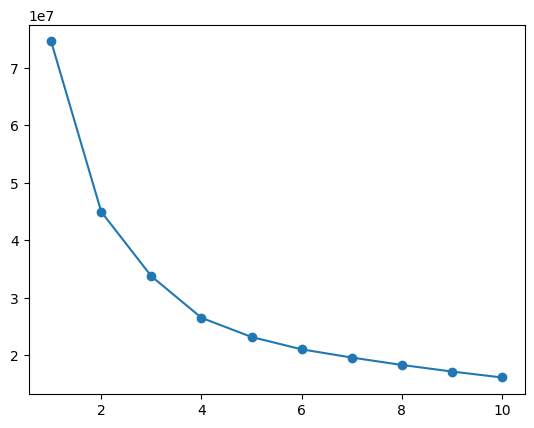

In [37]:
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

kmeans_values = df[["start_lat", "start_lng", "end_lat", "end_lng","ride_value", "start_day", "start_hour", "start_day_of_week", "distance"]].values

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(kmeans_values)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.show()

K = 3 seems to be the best choice, so we will cluster our rides into 3 clusters and check the distribution.

In [38]:
df_clustering = df.copy(deep=True)
kmeans = KMeans(n_clusters=3)
kmeans.fit(kmeans_values)
df_clustering["cluster"] = kmeans.labels_
df_clustering["cluster"].value_counts()

cluster
0    238750
1    207522
2    163920
Name: count, dtype: int64

In [41]:
colors = ["red", "yellow", "green"]

df_plot = df_clustering.sample(n=1000)
map = folium.Map(location=[df_plot["start_lat"].mean(), df_plot["start_lng"].mean()], zoom_start=11.5)
df_plot.apply(lambda row: folium.CircleMarker(location=[row["start_lat"], row["start_lng"]], radius=5, fill_color = colors[(row["cluster"])], fill=True, color=False, fill_opacity=1).add_to(map), axis=1)
map

The clusters seem somehow balanced (cluster 2 is the smallest but not small enough to be considered as an outlier cluster), and no small group of rides stands out and require further analysis.

the plot also shows that no cluster is well seperated geographically.

*2- Information about trip durations and drivers*

The provided data lack any information about the duration of the trip not the drivers (the supply), so we need to estimate it.

When a trip is finished, the driver in most cases are online and free to take another trip, so we can use the end coordinates as the most propable location of the free suppliers at a specific time. However, we cannot use the start_time as it is because each trip has a duration, but by estimating the trip duration (since we have the distance), we can have an estimation on the end_time of the trip and that can be used to determine the available suppliers more accuratly.

based on the following link,the speed in residentail areas in Estonia (based on what the map shows us) is set to 50 km/h, so we estimate the average speed to be around 40km/h due to delays and traffic jam.

https://www.rac.co.uk/drive/travel/country/estonia/#:~:text=Estonian%20speed%20limit,-There%20are%20no&text=In%20built%2Dup%20areas%2C%20the,to%20110%2Fkm%2Fh.

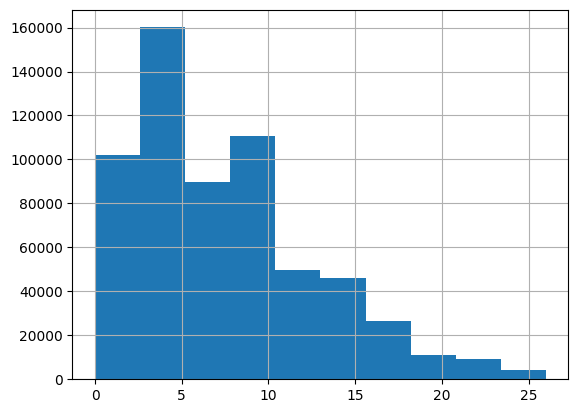

In [42]:
# speed = distance / time ==> time = distance / speed

df["trip_duration_hours"] = df["distance"] / 40
df["trip_duration_minutes"] = round(df["trip_duration_hours"] * 60).astype(int)

df["trip_duration_minutes"].hist();
plt.show()

using the trip duration, we can calculate the end_time and its metadata

In [43]:
def calculate_end_time(row):
    return row["start_time"] + pd.Timedelta(minutes=row["trip_duration_minutes"])

df["end_time"] = df.apply(lambda row: calculate_end_time(row), axis=1)

df["end_date"] = df["end_time"].dt.date
df["end_day"] = df["end_time"].dt.day
df["end_hour"] = df["end_time"].dt.hour
df["end_minute"] = df["end_time"].dt.minute
df["end_day_of_week"] = df["end_time"].dt.dayofweek 
df["end_day_of_week"] = df["end_day_of_week"] + 1

df.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,start_date,start_month,start_day,start_hour,...,distance,value_per_km,trip_duration_hours,trip_duration_minutes,end_time,end_date,end_day,end_hour,end_minute,end_day_of_week
589247,2022-03-01 00:00:07,59.438,24.729,59.553,24.803,3.35200,2022-03-01,3,1,0,...,13.479290,0.248678,0.336982,20,2022-03-01 00:20:07,2022-03-01,1,0,20,2
613394,2022-03-01 00:00:17,59.443,24.753,59.392,24.722,1.49500,2022-03-01,3,1,0,...,6.012515,0.248648,0.150313,9,2022-03-01 00:09:17,2022-03-01,1,0,9,2
557451,2022-03-01 00:00:20,59.432,24.768,59.434,24.729,0.55275,2022-03-01,3,1,0,...,2.260878,0.244485,0.056522,3,2022-03-01 00:03:20,2022-03-01,1,0,3,2
266890,2022-03-01 00:00:20,59.440,24.749,59.453,24.871,1.73725,2022-03-01,3,1,0,...,7.098048,0.244750,0.177451,11,2022-03-01 00:11:20,2022-03-01,1,0,11,2
191825,2022-03-01 00:00:25,59.368,24.645,59.396,24.800,2.28675,2022-03-01,3,1,0,...,9.345522,0.244689,0.233638,14,2022-03-01 00:14:25,2022-03-01,1,0,14,2


With this we can split our data into the following:

1- demand: location (start coordinates), temporal details (start date and time)

2- supply: location (end coordinates), temporal details (end date and time)

Using those 2 sets of data, we can create models to estimate the demand and the supply for each time point per each location, and determine the areas that have a lack in supply (to guide drivers from over-supply areas).

Since the training features are different per each prediction, we will build 2 models, one for supply prediction, and one for the demand prediction.

**Model Selection, Training, and Testing**

*Data Preparation*

In [44]:
demand_columns = ["start_lat", "start_lng", "start_day", "start_day_of_week", "start_hour"]

renaming_map = dict()
for c in demand_columns:
    renaming_map[c] = c.replace("start_", "")

demand_location_time = df.groupby(demand_columns, as_index=False)["ride_value"].count()

renaming_map["ride_value"] = "demand"

demand_location_time = demand_location_time.rename(columns=renaming_map)
demand_location_time.head()

,lat,lng,day,day_of_week,hour,demand
0,59.322,24.659,10,4,2,1
1,59.322,24.659,14,1,2,1
2,59.322,24.659,24,4,2,1
3,59.323,24.698,7,1,20,1
4,59.323,24.698,16,3,20,1


In [45]:
demand_location_time.shape

(461083, 6)

In [46]:
supply_columns = ["end_lat", "end_lng", "end_day", "end_day_of_week", "end_hour"]

renaming_map = dict()
for c in supply_columns:
    renaming_map[c] = c.replace("end_", "")

supply_location_time = df.groupby(supply_columns, as_index=False)["ride_value"].count()

renaming_map["ride_value"] = "supply"

supply_location_time = supply_location_time.rename(columns=renaming_map)
supply_location_time.head()

,lat,lng,day,day_of_week,hour,supply
0,59.235,24.683,5,6,18,1
1,59.237,24.688,14,1,3,1
2,59.237,24.688,21,1,3,1
3,59.242,24.660,14,1,21,1
4,59.242,24.660,20,7,21,1


In [47]:
supply_location_time.shape

(493647, 6)

*Model Selection*

We split the data into training and testing, and we use CV to determine the model with the best performance on the training data to use it then for predictions.

In [48]:
def get_train_test_data(df, target_column):
    df_X = df.drop(columns=[target_column])
    df_y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, shuffle=True, random_state=42)
    return X_train, X_test, y_train, y_test

X_train_d, X_test_d, y_train_d, y_test_d = get_train_test_data(demand_location_time, "demand")
X_train_s, X_test_s, y_train_s, y_test_s = get_train_test_data(supply_location_time, "supply")

In [49]:
models = {
    "LinearRegression": LinearRegression(),
    "Poisson": PoissonRegressor(),
    "Ridge": Ridge(alpha=1.0),
    "BayesianRidge": BayesianRidge(),
    "Polynomial": Pipeline([('poly', PolynomialFeatures(degree=2)), ('linear', LinearRegression())]),
    "RandomForestRegressor": RandomForestRegressor(max_depth=5, random_state=42),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "XGBRegressor": XGBRegressor()
}

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [50]:
def get_best_model(X_train, y_train):
    target = y_train.values.ravel()
    errors = dict()
    
    for model_name, model in models.items():
        pipeline = Pipeline([('scaler', MinMaxScaler()),('estimator', model)])
        scores  = cross_val_score(pipeline, X_train, target, cv=kfold, scoring="neg_mean_squared_error")
        mean_score = abs(mean(scores))
        print(f"{model_name}: {mean_score}")
        errors[model_name] = mean_score
    print("-----------------")
    print(f"the model with the min error: {min(errors, key=errors.get)}")

In [51]:
get_best_model(X_train_d, y_train_d)

LinearRegression: 1.0535106268631675
Poisson: 1.0566646231926264
Ridge: 1.053510622604034
BayesianRidge: 1.0535107419126406
Polynomial: 1.0206603134727552
RandomForestRegressor: 0.8659656763657644
DecisionTreeRegressor: 0.8431788673905057
XGBRegressor: 0.48775186890326416
-----------------
the model with the min error: XGBRegressor


In [52]:
get_best_model(X_train_s, y_train_s)

LinearRegression: 0.5473869588466823
Poisson: 0.5494115312010716
Ridge: 0.5473869531499953
BayesianRidge: 0.5473868982146225
Polynomial: 0.5374594896453867
RandomForestRegressor: 0.49663608967936684
DecisionTreeRegressor: 0.5966063481289289
XGBRegressor: 0.2997300133362257
-----------------
the model with the min error: XGBRegressor


*Model Training and Testing: Performance Evaluation*

XGBRegressor is the best model for both demand and supply and it's way faster than RF as well, so we train the model on the full training set, then we predict on the testing set and calculate the error to evaluate the performance.

In [53]:
def train_predict(X_train, y_train, X_test, y_test):

    model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1)

    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    feature_scaler.fit(X_train)
    X_train_scaled = feature_scaler.transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)

    train_target =  y_train.values.ravel()
    test_target = y_test.values.ravel()
    
    model.fit(X_train_scaled, train_target)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(test_target, y_pred)

    true_vs_predicted = pd.DataFrame({"true": test_target, "predicted": np.rint(y_pred)})

    return model, feature_scaler, true_vs_predicted, mse

In [54]:
demand_model, demand_scaler, demand_true_vs_predicted, demand_mse,  = train_predict(X_train_d, y_train_d, X_test_d, y_test_d)
supply_model, supply_scaler, supply_true_vs_predicted, supply_mse = train_predict(X_train_s, y_train_s, X_test_s, y_test_s)

print(f"demand MSE = {demand_mse}")
print(f"supply MSE = {supply_mse}")

demand MSE = 0.41353670619386346
supply MSE = 0.2884865121482506


In [ ]:
# export models and scalers to reuse for later predictions

with open('data/demand_model.pickle', 'wb') as fp:
    pickle.dump(demand_model, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open('data/demand_scaler.pickle', 'wb') as fp:
    pickle.dump(demand_scaler, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open('data/supply_model.pickle', 'wb') as fp:
    pickle.dump(supply_model, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open('data/supply_scaler.pickle', 'wb') as fp:
    pickle.dump(supply_scaler, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [55]:
def calculate_correct_predictions(df):
    df["correct"] = df.apply(lambda row: row["true"] == row["predicted"], axis=1)

    # we also calculate the "almost" correct predictions where the difference between true and prediction is no more than 1
    df["almost_correct"] = df.apply(lambda row: abs(row["true"] - row["predicted"]) <= 1, axis=1)

    return df

demand_true_vs_predicted = calculate_correct_predictions(demand_true_vs_predicted)
supply_true_vs_predicted = calculate_correct_predictions(supply_true_vs_predicted)

In [56]:
demand_true_vs_predicted["correct"].value_counts(normalize=True)*100

correct
True     79.111227
False    20.888773
Name: proportion, dtype: float64

In [57]:
demand_true_vs_predicted["almost_correct"].value_counts(normalize=True)*100

almost_correct
True     96.06797
False     3.93203
Name: proportion, dtype: float64

In [58]:
supply_true_vs_predicted["correct"].value_counts(normalize=True)*100

correct
True     83.375874
False    16.624126
Name: proportion, dtype: float64

In [59]:
supply_true_vs_predicted["almost_correct"].value_counts(normalize=True)*100

almost_correct
True     97.203484
False     2.796516
Name: proportion, dtype: float64

*Model Output Interpretation*

a pretty straightforward interpretatoin of the outputs is to calculate the difference between the estimated supply and demand in of a location at a certain time and then determine whether more drivers need to be guided to this location, or instead, encourage them to move due to the over-supply.

In [60]:
demand_prediction_data = X_test_d.copy(deep=True)
demand_prediction_data["true_demand"] = demand_true_vs_predicted["true"].values
demand_prediction_data["predicted_demand"] = demand_true_vs_predicted["predicted"].values

demand_prediction_data["predicted_demand"] = demand_prediction_data["predicted_demand"].astype(int)
demand_prediction_data.head()

,lat,lng,day,day_of_week,hour,true_demand,predicted_demand
26674,59.391,24.717,12,6,14,1,1
61604,59.403,24.724,24,4,12,1,1
71313,59.405,24.819,21,1,5,1,1
81261,59.408,24.642,14,1,18,1,1
62194,59.403,24.734,18,5,16,1,1


In [61]:
supply_prediction_data = X_test_s.copy(deep=True)
supply_prediction_data["true_supply"] = supply_true_vs_predicted["true"].values
supply_prediction_data["predicted_supply"] = supply_true_vs_predicted["predicted"].values

supply_prediction_data["predicted_supply"] = supply_prediction_data["predicted_supply"].astype(int)
supply_prediction_data.head()

,lat,lng,day,day_of_week,hour,true_supply,predicted_supply
279207,59.433,24.758,24,4,5,2,1
56123,59.399,24.689,5,6,21,1,1
294993,59.434,24.796,8,2,20,1,1
62390,59.401,24.671,24,4,22,1,1
230522,59.429,24.747,26,6,0,1,1


In [63]:
with pd.ExcelWriter("prediction_details.xlsx") as writer:
    supply_prediction_data.to_excel(writer, sheet_name="supply", index=False)
    demand_prediction_data.to_excel(writer, sheet_name="demand", index=False)

In [64]:
demand_vs_supply = pd.merge(demand_prediction_data, supply_prediction_data, how="inner", on = ["lat", "lng", "day", "day_of_week", "hour"])
demand_vs_supply.head()

,lat,lng,day,day_of_week,hour,true_demand,predicted_demand,true_supply,predicted_supply
0,59.445,24.762,24,4,10,1,1,2,2
1,59.397,24.713,18,5,6,1,1,3,1
2,59.428,24.776,17,4,2,1,1,1,1
3,59.417,24.799,3,4,7,2,3,3,3
4,59.419,24.644,8,2,22,1,1,1,1


In [65]:
demand_vs_supply.iloc[0]

lat                 59.445
lng                 24.762
day                 24.000
day_of_week          4.000
hour                10.000
true_demand          1.000
predicted_demand     1.000
true_supply          2.000
predicted_supply     2.000
Name: 0, dtype: float64

In [66]:
x = demand_vs_supply.iloc[0]["lat"]
y = demand_vs_supply.iloc[0]["lng"]

location = geolocator.reverse(str(x)+","+str(y)).raw["address"]

print(location["road"], location["quarter"], location["suburb"], location["postcode"], location["city"])

Sadama Sadama Kesklinna linnaosa 10151 Tallinn


In [67]:
demand_vs_supply.iloc[0]["predicted_demand"]

1.0

In [68]:
demand_vs_supply.iloc[0]["predicted_supply"]

2.0

we notice that for the following location "Sadama Sadama Kesklinna linnaosa 10151 Tallinn", the predicted demand on 24 March (Thursday) at 10 a.m. is 1 ride, while the available supply at that time is 2 drivers, so 1 driver can be guided to another location where there is a supply lack.

**System Design and Deployment**

the suggested solution can provide 2 different outputs at once:

1- What is the expected demand/supply in a specific location at a specific day/time?

2- What are the areas which are expected to have a lack of demand at a specific day/time?

*Predict the demand/supply*

A post API can be implemented to call the prediction function for a query passed by the drivers, where the required input is the location and the day/time.

a page to the drivers mobile app can be created where the drivers can select the desired location by clicking on the map (this will fetch the coordinates) and select the date and time from a calendar, then the prediction output will be provided. The map and the calendar are easy to use to prevent drivers from being distracted while driving.

Creating the API: Azure Function Apps or FastAPI can be used to create the API.

Pydantic is an example of schema validation that can be used to make sure we are receiving the correct input features and returning the correct output in the format that the mobile app can easily parse.

The pretrained models/scalers can be exported as pickle files to be reused.

Pip or poetry can be used to define the required dependencies and their versions for the release, and to split the dependencies themselves to differentaite between the ones related to the API itself and the ones related to the other operations (model training, unit tests, ploting).

*Batch predictions*

get information in real time about the expected supply vs. demand in each location of the city and provide recommendations for the drivers to go to the areas where a lack in supply is expected soon (before happening). This can even be enhanced to recommend drivers to go to the closest location to their current one to minimize their driving time and make their work more profitable.,

This needs to perform the following tasks continuously: accessing the pretrained model, perform predictions for all locations per each time unit, broadcast the locations that need more supply in a specific time to the closest drivers before the demand actually happen so the drivers can be there on time.


Azure functions for example allow the execution of functions to be triggered at specific time or by certain events, and this feature can be helpful to perform the predictions and then share the results with the respective drivers. The recommendations can then be broadcasted to the respective drivers mentioning the desired location and time (can also be linked to be read by google assistant or a similar technology to avoid distraction while driving).


*Data Collection and Model Retraining*

New data should always be aggregated and the models should be retrained periodically to make sure that any new pattern is correctly caught and learnt. 

The data can be saved in a DB, for example PostgresSQL which can be easily integrated with the Cloud (Azure for example) to allow an easy and secured access to the data.

On the cloud, the training code can be prepared and set to be triggered when new data is available (For example, every week), and the new trained models can be immediately exported and set in a blob storage for example to be accessed by the Post API and the batch predictions service.

If we take Azure ML as an example, an experiment can be defined to host the training code that will be executed repeatidly, in addition to defining the performance metrics that need to be logged after each training process.

It is also important to use logs inside the code to be able to maintain the performance and have access to any possible error, so that it can easily be fixed.

*Notebooks*

Cloud notebooks can also be set to perform EDA and provide insights and useful analysis when new data is aggregated. Those notebooks can also be scheduled to be executed at some timepoint to have a report than can be shared with the stakeholders and any relavent party (including the data teams, marketing teams, etc).

**Future Enhancements and Suggestions**

*Trip Durations*

Trip durations were estimated. However, some hours during the day would correspond to longer durations such as rush hours. So providing the exact trip durations would give better estimations on the end_date and its metadata to better estimate the drivers locations and the supply estimations.

*Ride Value*

The suggested solution discuss detecting the areas which would have a supply lack at a certain time point and guiding the drivers to those areas. Another possibility is to include the ride value itself as a factor to guide the drivers not only to the closest locations with an upcoming supply lack but also to the areas where rides are more profitable.

Helpful features: the ride value, the value per kilometer, the average ride value, the locations where at certain time points, rare but very profitable rides are booked such as to the airport.


*Additional Features*

1- monthly patterns: when having data for different months, we can get insights and patterns related to the seasons and the special events and holidays.

2- weather information: usually, on rainy days, taxis are ordered more since the usage of public transportation is less convenient, so including the weather conditions might be helpful to make better predictions about the demand changes.

3- travel information: a plane arriving at a late hour at night might cause a high and a very profitable demand, so incorporating information from the airports and the long distance trains would be helpful.

**Validation Experiment** 

A/B testing can be used to validate the suggested solution for live operations since it's a method to compare 2 versions of a system (web page, app, etc.) to determine which one performs better. Details are as the following:

1- Determine the goals and what to measure: the goals are to make sure higher profits are made, riders are better served, and riders are more satisfied. In this case we can measure the number of served riders, the average waiting time of the riders, the count of canceled rides due to long waiting time, and the average time where drivers are in the Idle status (moving without a customer).

2- Split the drivers into 2 equal, well balances sets (randomly sampled taking days and different shifts into account and making sure every category is represented in both the control and the treatment groups).

3- Set the hypothesis: the treatment group will have higher profits, less waiting and idle times, more served riders, and less cancelations. The null hypothesis is that the current version of the app (linked to the control group) is better.

4- Perform the test: for the cotrol group, keep the current version of the drivers app, while setting the updated version with the query functionality and the broadcasted recommendations to the treatment group. Then let the drivers do their job for the set period of the experience (1 week for example).

5- Log all the previously mentioned information then calculate the performance metrics per each group.

6- Calculate the p-value to determine if we can reject the null hypothesis.

7- Compare between the perfomance of the 2 groups by providing the raw numbers and useful charts and plots.

8- Make a decision with the Stakeholders.